## Idefics2-8B

Idefics2-8B is a open source Multi Modal Image to Text model specifically trained to extract information from images. The model can answer questions about images, describe visual content, create stories grounded on multiple images, or simply behave as a pure language model without visual inputs.

The people who have developed this model have also released the model weights, so the model can be fine tuned for specific use cases.

[Model Card](https://huggingface.co/HuggingFaceM4/idefics2-8b)

### Install the required Dependencies

In [ ]:
!pip install huggingface-hub

In [ ]:
!pip install bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 14.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [2]:
!pip install transformers --upgrade

In [ ]:
!pip install -q accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 807.8 kB/s eta 0:00:00


In [1]:
!pip install Pillow


### Load and setup the Model

In [ ]:
from huggingface_hub import notebook_login                    # Log into your hugging face account using the secret token
                                                              # Copy paste the Hugging-Face access keys in the cell below
notebook_login()

In [ ]:
from transformers import BitsAndBytesConfig
import torch
from transformers import AutoProcessor, AutoModelForVision2Seq                  # I'm using BitsandBytes to load a 4-bit quantised version of the model, this will make sure that the entire model
from transformers.image_utils import load_image                                 # will be able to fit on a T4 gpu on colab while having almost the same performance of the full size model

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16
)
model = AutoModelForVision2Seq.from_pretrained(
    "HuggingFaceM4/idefics2-8b",
    torch_dtype=torch.float16,
    quantization_config=quantization_config,                                    # Please Note: the model shards are quite big and will take a while to download
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/74.4k [00:00<?, ?B/s]

model-00001-of-00007.safetensors:   0%|          | 0.00/4.64G [00:00<?, ?B/s]

model-00002-of-00007.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00007.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00004-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00006-of-00007.safetensors:   0%|          | 0.00/4.83G [00:00<?, ?B/s]

model-00007-of-00007.safetensors:   0%|          | 0.00/4.25G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [ ]:
import requests
import torch
from PIL import Image
from io import BytesIO

from transformers import AutoProcessor, AutoModelForVision2Seq
from transformers.image_utils import load_image


DEVICE = "cuda:0"


def ask_question(query, Image):                                                 # Function that takes in the query and the image as the inputs and returns the output of the query if it found any

    messages = [
        {
            "role": "user",
            "content": [                                                        # Change the prompt depending on the use case, I will be using the model to answer questions from invoices hence the prompt
                {"type": "text", "text": '''You are an Expert at summarising information by looking at the images, you will be provided with an image along with a question,
                                          Using the image as a reference, answer the question.'''},
                {"type": "image"},
                {"type": "text", "text": query}
            ]
        }
    ]


    processor = AutoProcessor.from_pretrained("HuggingFaceM4/idefics2-8b")
    prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(text=prompt, images=[Image], return_tensors="pt")



    generated_ids = model.generate(**inputs, max_new_tokens=500)
    generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

    return generated_texts

### Loading the Images

In [3]:
from PIL import Image
from transformers.image_utils import load_image                                 # The import required to read the image

image1 = load_image("/content/classic_invoice.png")
image2 = load_image("/content/v4-460px-Make-an-Invoice-Step-9-Version-3.jpg.jfif")
image3 = load_image("/content/6572fdb717211ce3d9d7bef7_Emergency Medical Form Example (Sample).png")
image4 = load_image("/content/ICSE-English-Language-Class-X-Handwritten-Notes-35-320.webp")


### Testing on Invoice Image

The invoice image is a straight forward image to test on as the items in the invoice have been clearly listed.

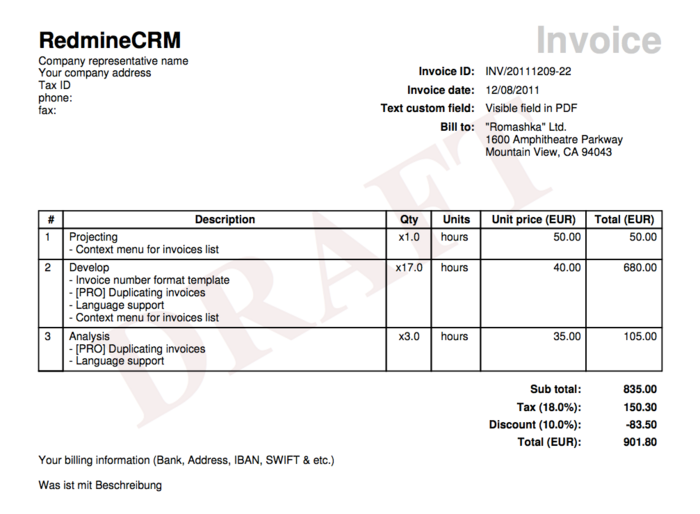

In [4]:
image1

In [ ]:
ask_question("What is the Invoice ID , Invoice Date and who is the Invoice Billed to?", image1)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['User: You are an Expert at summarising information by looking at the images, you will be provided with an image along with a question,\n                                          Using the image as a reference, answer the question. What is the Invoice ID , Invoice Date and who is the Invoice Billed to? \nAssistant: Invoice ID: INV20111209-22, Invoice Date: 12/08/2011, Bill To: "Romashka" Ltd.']

In [ ]:
ask_question("What is the tax and Discount Applied to this invoice?", image1)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['User: You are an Expert at summarising information by looking at the images, you will be provided with an image along with a question,\n                                          Using the image as a reference, answer the question. What is the tax and Discount Applied to this invoice? \nAssistant: Tax (18.0%): 150.35, Discount (10.0%): -83.50.']

In [ ]:
ask_question("In what curreny is the bill generated?", image1)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['User: You are an Expert at summarising information by looking at the images, you will be provided with an image along with a question,\n                                          Using the image as a reference, answer the question. In what curreny is the bill generated? \nAssistant: The bill is generated in Euros.']

### Testing on 2nd Invoice Image

Testing on a second image of an Invoice but this time the quality of the image is not great so making it slightly challenging for the llm.

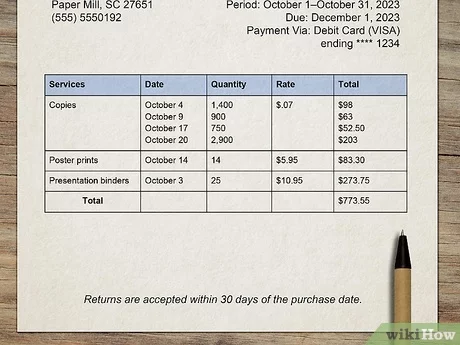

In [5]:
image2

In [ ]:
ask_question("How was the payment for this Invoice Completed?", image2)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['User: You are an Expert at summarising information by looking at the images, you will be provided with an image along with a question,\n                                          Using the image as a reference, answer the question. How was the payment for this Invoice Completed? \nAssistant: Payment via Debit Card.']

In [ ]:
ask_question("For which period is this invoice dated?", image2)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['User: You are an Expert at summarising information by looking at the images, you will be provided with an image along with a question,\n                                          Using the image as a reference, answer the question. For which period is this invoice dated? \nAssistant: This invoice is dated October 1- October 31, 2023.']

In [ ]:
ask_question("What is the quantity of Poster Prints?", image2)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['User: You are an Expert at summarising information by looking at the images, you will be provided with an image along with a question,\n                                          Using the image as a reference, answer the question. What is the quantity of Poster Prints? \nAssistant: The quantity of Poster Prints is 14.']

In [ ]:
ask_question("What is the per unit rate for Copies and Presentation Binders?", image2)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['User: You are an Expert at summarising information by looking at the images, you will be provided with an image along with a question,\n                                          Using the image as a reference, answer the question. What is the per unit rate for Copies and Presentation Binders? \nAssistant: The per unit rate for Copies is $0.07 and the per unit rate for Presentation binders is $5.95.']

In [ ]:
ask_question("When are Returns Accepted?", image2)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['User: You are an Expert at summarising information by looking at the images, you will be provided with an image along with a question,\n                                          Using the image as a reference, answer the question. When are Returns Accepted? \nAssistant: Within 30 days of the purchase date.']

### Testing the Medical Records Image

Moving onto testing on a Medical Form to prove that this model can be used in Medical and other scenarios where the privacy is cruical and the amount of information on the image is much greater than the information present in the first two test images.

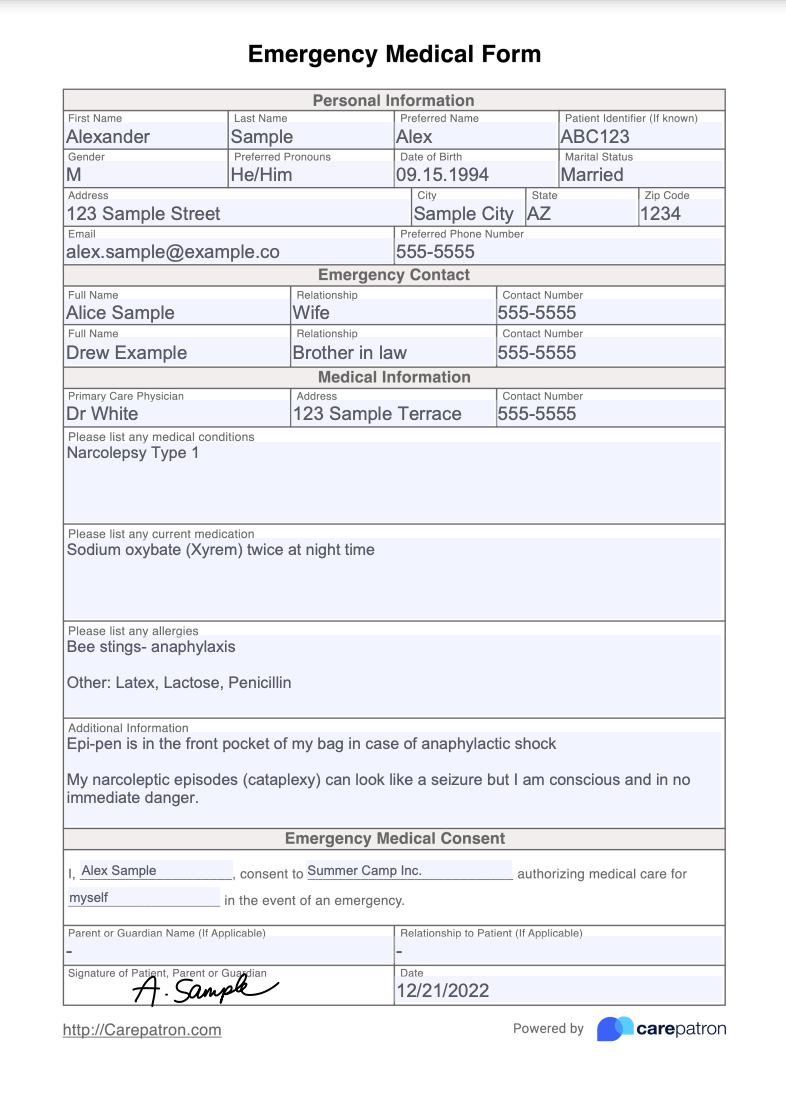

In [6]:
image3

In [ ]:
ask_question("What is the First Name, Last Name and Preffered Name of the Patient?", image3)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['User: You are an Expert at summarising information by looking at the images, you will be provided with an image along with a question,\n                                          Using the image as a reference, answer the question. What is the First Name, Last Name and Preffered Name of the Patient? \nAssistant: Alexander, Sam, Alex.']

In [ ]:
ask_question("What is the address, city and the state of the Patient?", image3)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['User: You are an Expert at summarising information by looking at the images, you will be provided with an image along with a question,\n                                          Using the image as a reference, answer the question. What is the address, city and the state of the Patient? \nAssistant: 123 Sample Street, City, AZ.']

In [ ]:
ask_question("What are Names of the Patient's Emergency Contacts?", image3)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


["User: You are an Expert at summarising information by looking at the images, you will be provided with an image along with a question,\n                                          Using the image as a reference, answer the question. What are Names of the Patient's Emergency Contacts? \nAssistant: Alice Sample, Drew Example."]

In [ ]:
ask_question("Who is the Patient's Physician?", image3)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


["User: You are an Expert at summarising information by looking at the images, you will be provided with an image along with a question,\n                                          Using the image as a reference, answer the question. Who is the Patient's Physician? \nAssistant: Dr. White."]

In [ ]:
ask_question("What Medication is the Patient Currently on?", image3)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['User: You are an Expert at summarising information by looking at the images, you will be provided with an image along with a question,\n                                          Using the image as a reference, answer the question. What Medication is the Patient Currently on? \nAssistant: Patient is currently on Sodium Oxybate.']

In [ ]:
ask_question("What Allergies does the patient have?", image3)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['User: You are an Expert at summarising information by looking at the images, you will be provided with an image along with a question,\n                                          Using the image as a reference, answer the question. What Allergies does the patient have? \nAssistant: Bee stings, penicillin.']

In [ ]:
ask_question("What complete Additional Information did the patient declare in the form?", image3)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['User: You are an Expert at summarising information by looking at the images, you will be provided with an image along with a question,\n                                          Using the image as a reference, answer the question. What complete Additional Information did the patient declare in the form? \nAssistant: Epipen is in the front pocket of my bag in case of anaphylactic shock.']

In [ ]:
ask_question("When was the form filled out?", image3)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['User: You are an Expert at summarising information by looking at the images, you will be provided with an image along with a question,\n                                          Using the image as a reference, answer the question. When was the form filled out? \nAssistant: 12/21/2022.']

### Testing the Model on Handwritten Image

Now this test really is mindblowing 🤯🤯, Traditionally there was a lot of difficulty in trying to read handwritten text even for closed source products from cloud providers such as AWS, Azure etc, so for an open source model to perform so well truly is fascinating and opens the door to so many possibilities. Plus, the input for these tests are not exactly images saved locally, but only a link to an image making it so much more convenient. The other really exciting thing is that the creators of this model have released the weights for this model which means it can be fine tuned for specific use cases which is just amazing.

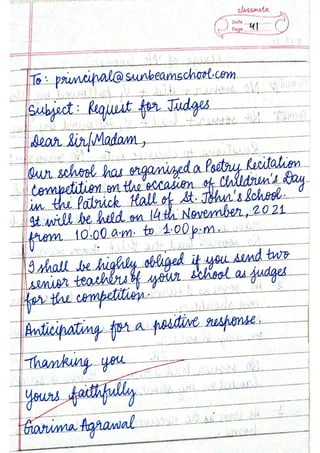

In [7]:
image4

In [ ]:
ask_question("Who is the letter addressed to?", image4)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['User: You are an Expert at summarising information by looking at the images, you will be provided with an image along with a question,\n                                          Using the image as a reference, answer the question. Who is the letter addressed to? \nAssistant: The letter is addressed to the principal.']

In [ ]:
ask_question("What is the email-id of the principal?", image4)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['User: You are an Expert at summarising information by looking at the images, you will be provided with an image along with a question,\n                                          Using the image as a reference, answer the question. What is the email-id of the principal? \nAssistant: Principal@sunbeamschool.com.']

In [ ]:
ask_question("What is the subject of the Letter?", image4)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['User: You are an Expert at summarising information by looking at the images, you will be provided with an image along with a question,\n                                          Using the image as a reference, answer the question. What is the subject of the Letter? \nAssistant: The subject of the letter is a request for judges for a Poetry Recitation competition.']

In [ ]:
ask_question("When is the Poetry Recitation competition held?", image4)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['User: You are an Expert at summarising information by looking at the images, you will be provided with an image along with a question,\n                                          Using the image as a reference, answer the question. When is the Poetry Recitation competition held? \nAssistant: The Poetry Recitation competition is held on the 14th November, 2021.']

In [ ]:
ask_question("How many Teachers Did the letter request?", image4)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['User: You are an Expert at summarising information by looking at the images, you will be provided with an image along with a question,\n                                          Using the image as a reference, answer the question. How many Teachers Did the letter request? \nAssistant: Two.']

Open sourcing such powerfull models is why I love the Generative AI space so much and I'm very excited to see what other innovation will be done in this space.